In [1]:
import os
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

In [2]:
# Add project root to path to import custom utils
# Adjust the number of parent calls if your notebook is nested deeper
try:
    PROJECT_ROOT = Path(__file__).parent.parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd().parent.parent

sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project Root: {PROJECT_ROOT}")

from utils.experiment_analysis import ExperimentAnalyzer
from utils.experiment_manager import ExperimentManager
# Set plotting style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")
sns.set_style("whitegrid")

Project Root: /home/minhang/mds_project/sc_classification


In [3]:
# In your notebook, update the 'Define Experiment Paths' cell

BASE_EXPERIMENT_DIR = PROJECT_ROOT / "experiments"

# --- Update this dictionary with your new experiment ID ---
EXPERIMENT_IDS = [
    "20250811_015935_fa_100_random_all_filtered_9be6903b",
    "20250811_022711_fa_100_random_deg_weak_screen_95a75afb",
    "20250811_025926_fa_100_random_all_filtered-hvg_d649c8b5",
    "20250811_170003_fa_100_random_deg_weak_screen_d6fa547e" # New stringent run
]

# Create a helper dictionary to manage experiments
experiments = {
    "all_filtered": {
        "id": EXPERIMENT_IDS[0],
        "path": BASE_EXPERIMENT_DIR / EXPERIMENT_IDS[0],
        "label": "All Genes (Filtered)"
    },
    "deg_weak_screen": { # Renamed key for clarity
        "id": EXPERIMENT_IDS[1],
        "path": BASE_EXPERIMENT_DIR / EXPERIMENT_IDS[1],
        "label": "DEG Screen (p < 0.1)"
    },
    "filtered_hvg": {
        "id": EXPERIMENT_IDS[2],
        "path": BASE_EXPERIMENT_DIR / EXPERIMENT_IDS[2],
        "label": "Filtered + HVG (3k)"
    },
    "deg_stronger_screen": { # Your new experiment
        "id": EXPERIMENT_IDS[3],
        "path": BASE_EXPERIMENT_DIR / EXPERIMENT_IDS[3],
        "label": "Stronger DEG Screen (q < 0.05)"
    }
}

# Verify that the paths exist
for key, exp_data in experiments.items():
    if not exp_data["path"].exists():
        print(f"ERROR: Experiment directory not found at {exp_data['path']}")

#### Investigate the gene lists produced by each preprocessing strategy
The "Weak DEG Screen" is a feature selection strategy designed to identify a broad set of genes that show at least some evidence of being differentially expressed between our target classes ('cancer' vs. 'normal'). It's intentionally less strict than a formal DEG analysis to capture a wider biological signal.

1. Comparison: It directly compares the 'cancer' group to the 'normal' group within the MRD-timepoint cells.
2. Statistical Test: It uses the non-parametric Wilcoxon rank-sum test (via scanpy.tl.rank_genes_groups) to calculate a p-value for each gene.
3. Initial Selection: It selects all genes with an unadjusted p-value less than 0.1. This is the "weak screen" criteria.
4. Minimum Gene Count: The method ensures that at least 3000 genes are selected. If the p-value threshold results in fewer than 3000 genes, it tops up the list with the most significant genes (lowest p-values) until the minimum count is reached.

Loaded gene list for 'All Genes (Filtered)': 36601 genes.
Loaded gene list for 'DEG Screen (p < 0.1)': 34587 genes.
Loaded gene list for 'Filtered + HVG (3k)': 3000 genes.
Loaded gene list for 'Stronger DEG Screen (q < 0.05)': 34216 genes.

--- Comparison 1: WEAK DEG Screen vs. HVG ---


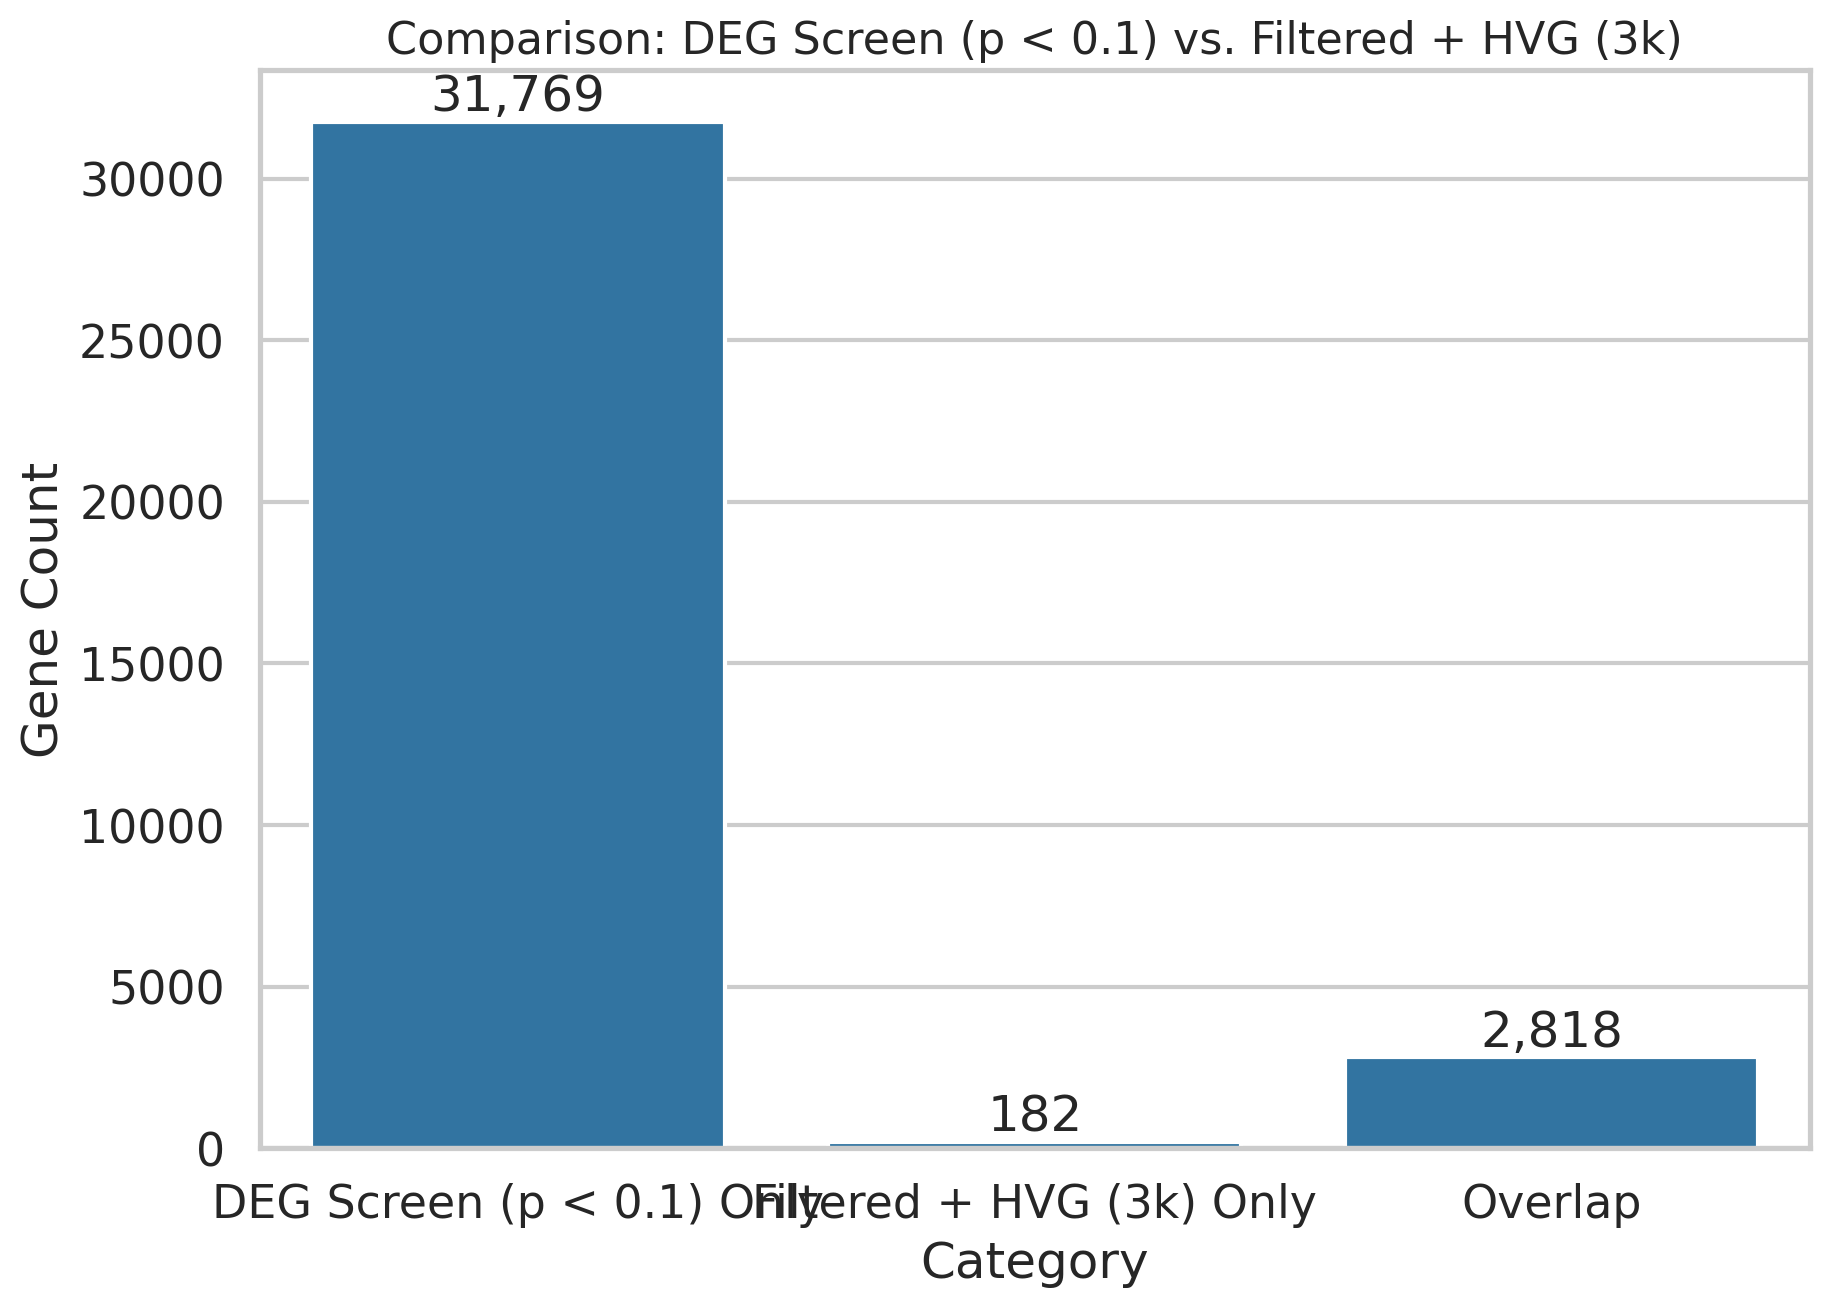

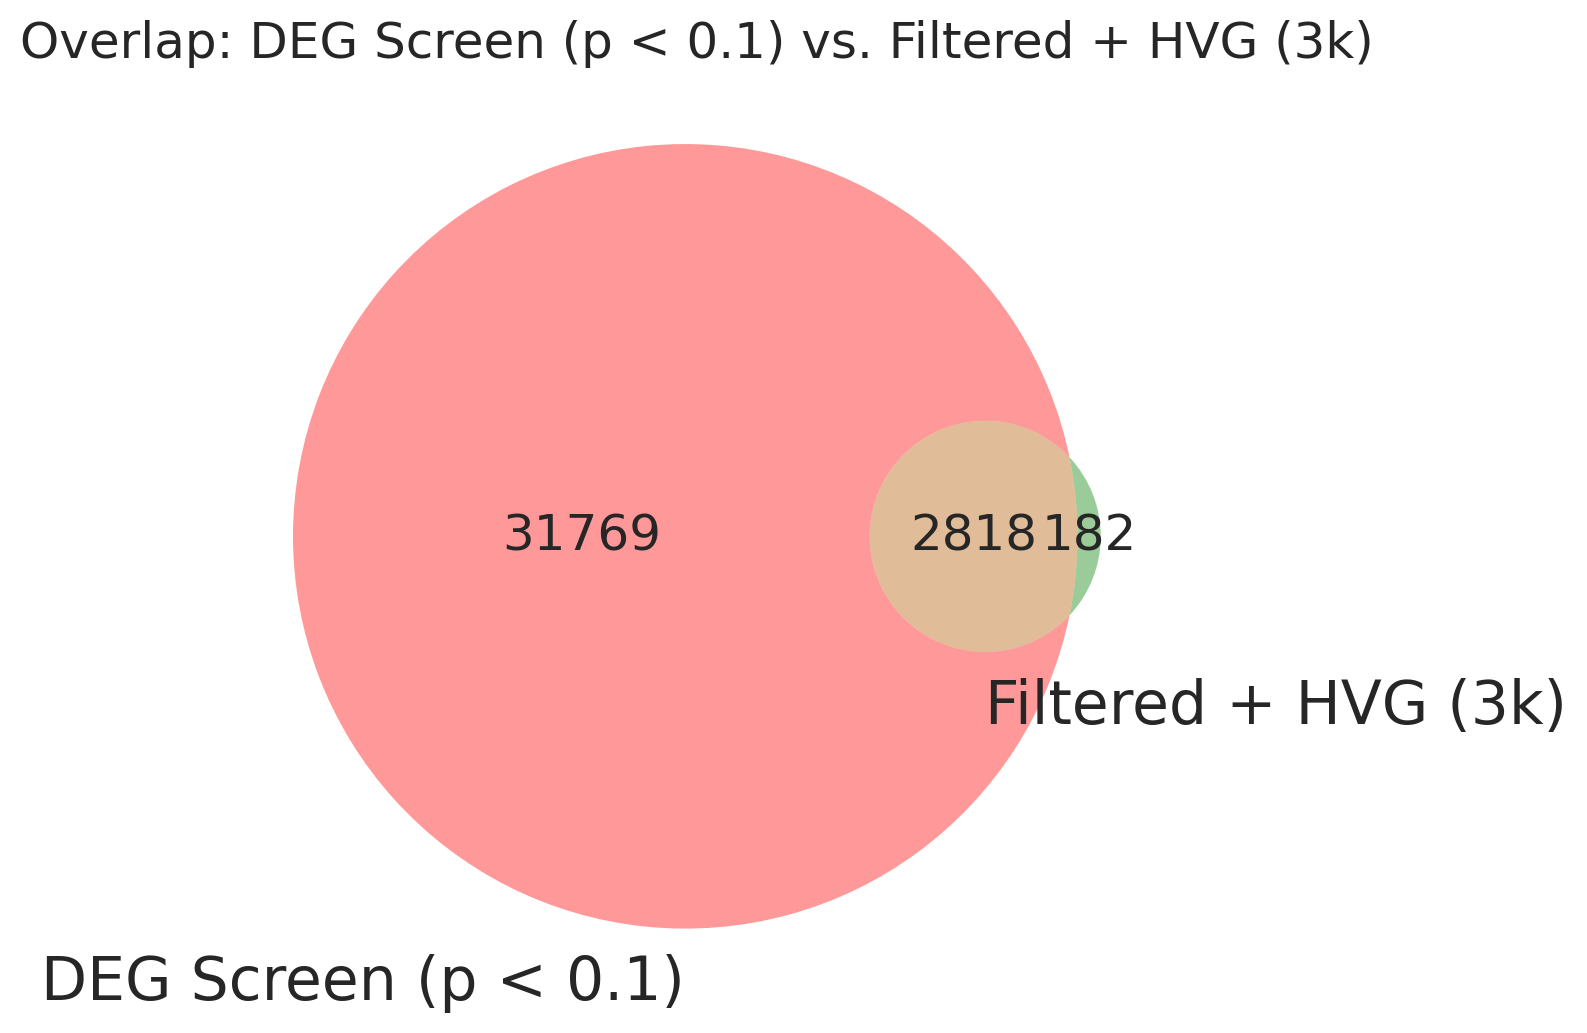


--- Comparison 2: STRONGER DEG Screen vs. HVG ---


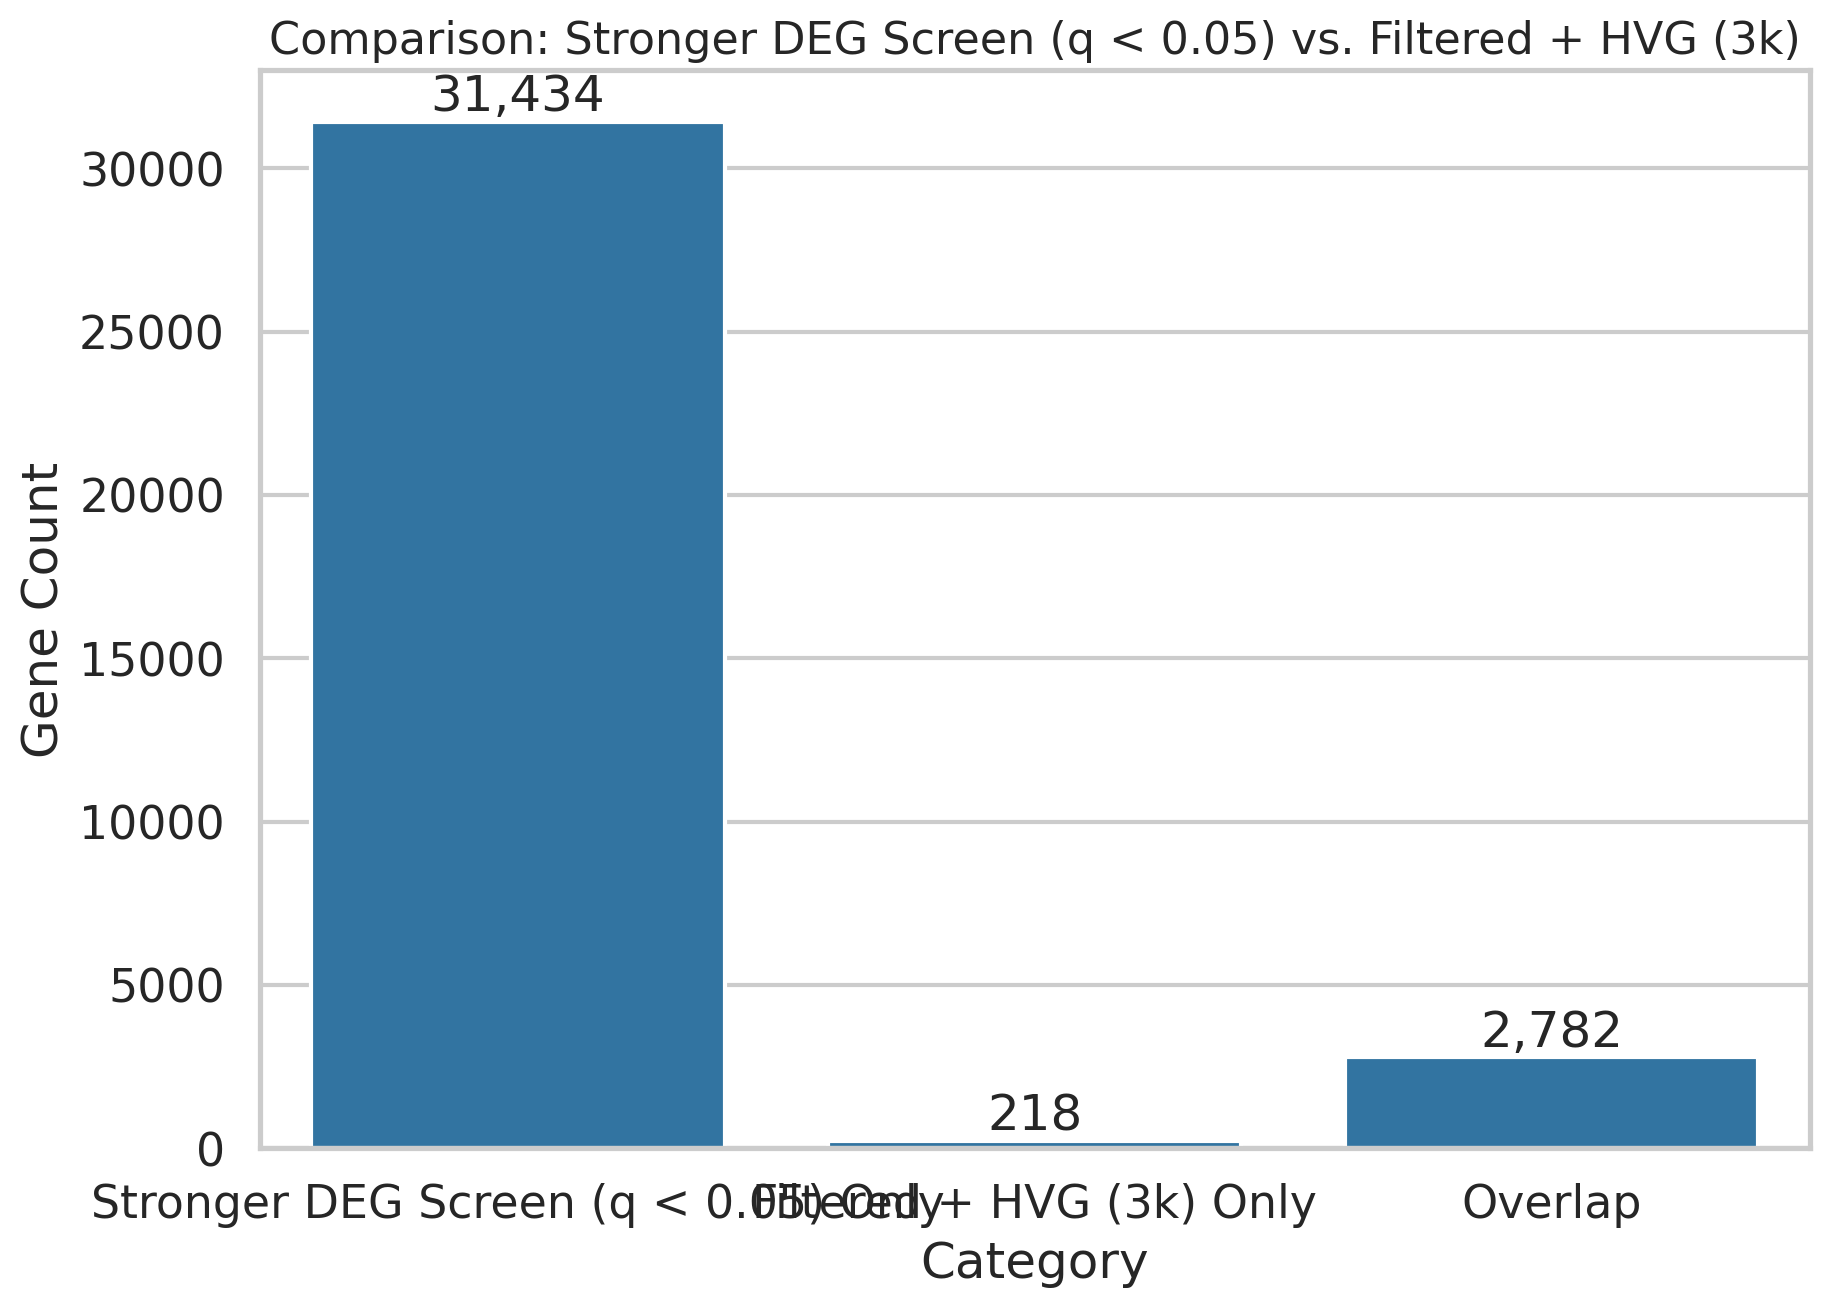

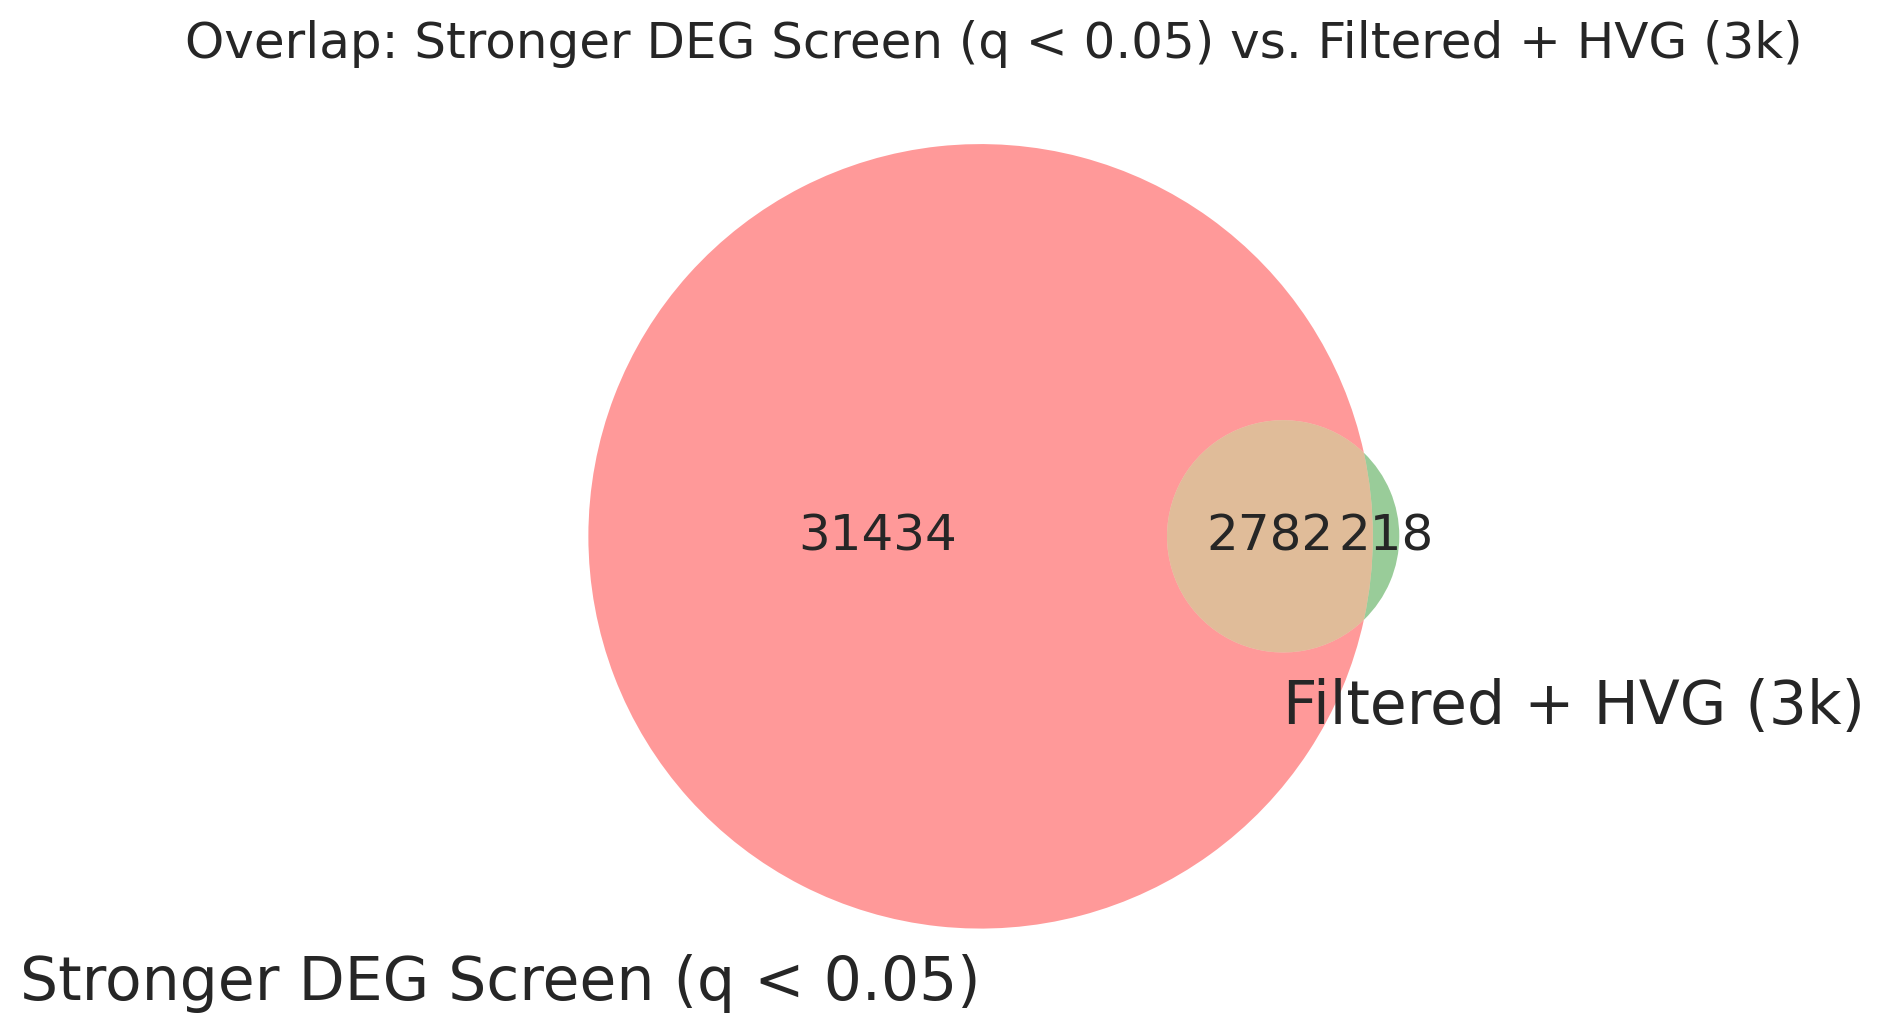

In [10]:
# In your notebook, replace the old gene list comparison cell with this:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd
import seaborn as sns

# Load all gene lists
gene_lists = {}
for key, exp_data in experiments.items():
    gene_list_path = exp_data["path"] / "preprocessing" / "hvg_list.pkl"
    with open(gene_list_path, 'rb') as f:
        gene_lists[key] = set(pickle.load(f)) # Use sets directly
        print(f"Loaded gene list for '{exp_data['label']}': {len(gene_lists[key])} genes.")

# --- Define a function to create comparison plots ---
def plot_set_comparison(set1, set2, set1_label, set2_label):
    overlap_count = len(set1.intersection(set2))
    set1_only_count = len(set1 - set2)
    set2_only_count = len(set2 - set1)

    # Bar Chart (Clearer)
    plot_data = pd.DataFrame({
        'Category': [f'{set1_label} Only', f'{set2_label} Only', 'Overlap'],
        'Gene Count': [set1_only_count, set2_only_count, overlap_count]
    })
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x='Category', y='Gene Count', data=plot_data)
    ax.set_title(f'Comparison: {set1_label} vs. {set2_label}', fontsize=16)
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.show()

    # Venn Diagram
    plt.figure(figsize=(8, 6))
    venn2([set1, set2], set_labels=(set1_label, set2_label))
    plt.title(f"Overlap: {set1_label} vs. {set2_label}")
    plt.show()

# --- Run comparisons ---
print("\n--- Comparison 1: WEAK DEG Screen vs. HVG ---")
plot_set_comparison(gene_lists['deg_weak_screen'], gene_lists['filtered_hvg'], 
                    'DEG Screen (p < 0.1)', 'Filtered + HVG (3k)')

print("\n--- Comparison 2: STRONGER DEG Screen vs. HVG ---")
plot_set_comparison(gene_lists['deg_stronger_screen'], gene_lists['filtered_hvg'], 
                    'Stronger DEG Screen (q < 0.05)', 'Filtered + HVG (3k)')

In [11]:
print(len(set(gene_lists['all_filtered'])))
print(len(set(gene_lists['deg_weak_screen'])))
print(len(set(gene_lists['filtered_hvg'])))
print(len(set(gene_lists['deg_stronger_screen'])))

36601
34587
3000
34216


Volcano plots for DEG based preprocess

--- Loading Gene Lists for Plotting ---
Loaded gene list for 'All Genes (Filtered)': 36601 genes.
Loaded gene list for 'DEG Screen (p < 0.1)': 34587 genes.
Loaded gene list for 'Filtered + HVG (3k)': 3000 genes.
Loaded gene list for 'Stronger DEG Screen (q < 0.05)': 34216 genes.

--- Generating Volcano Plots for DEG Screens ---
Loading and preparing base filtered data...


Base filtered data shape: (69801, 36601)

Calculating DEGs for WEAK screen (p < 0.1)...


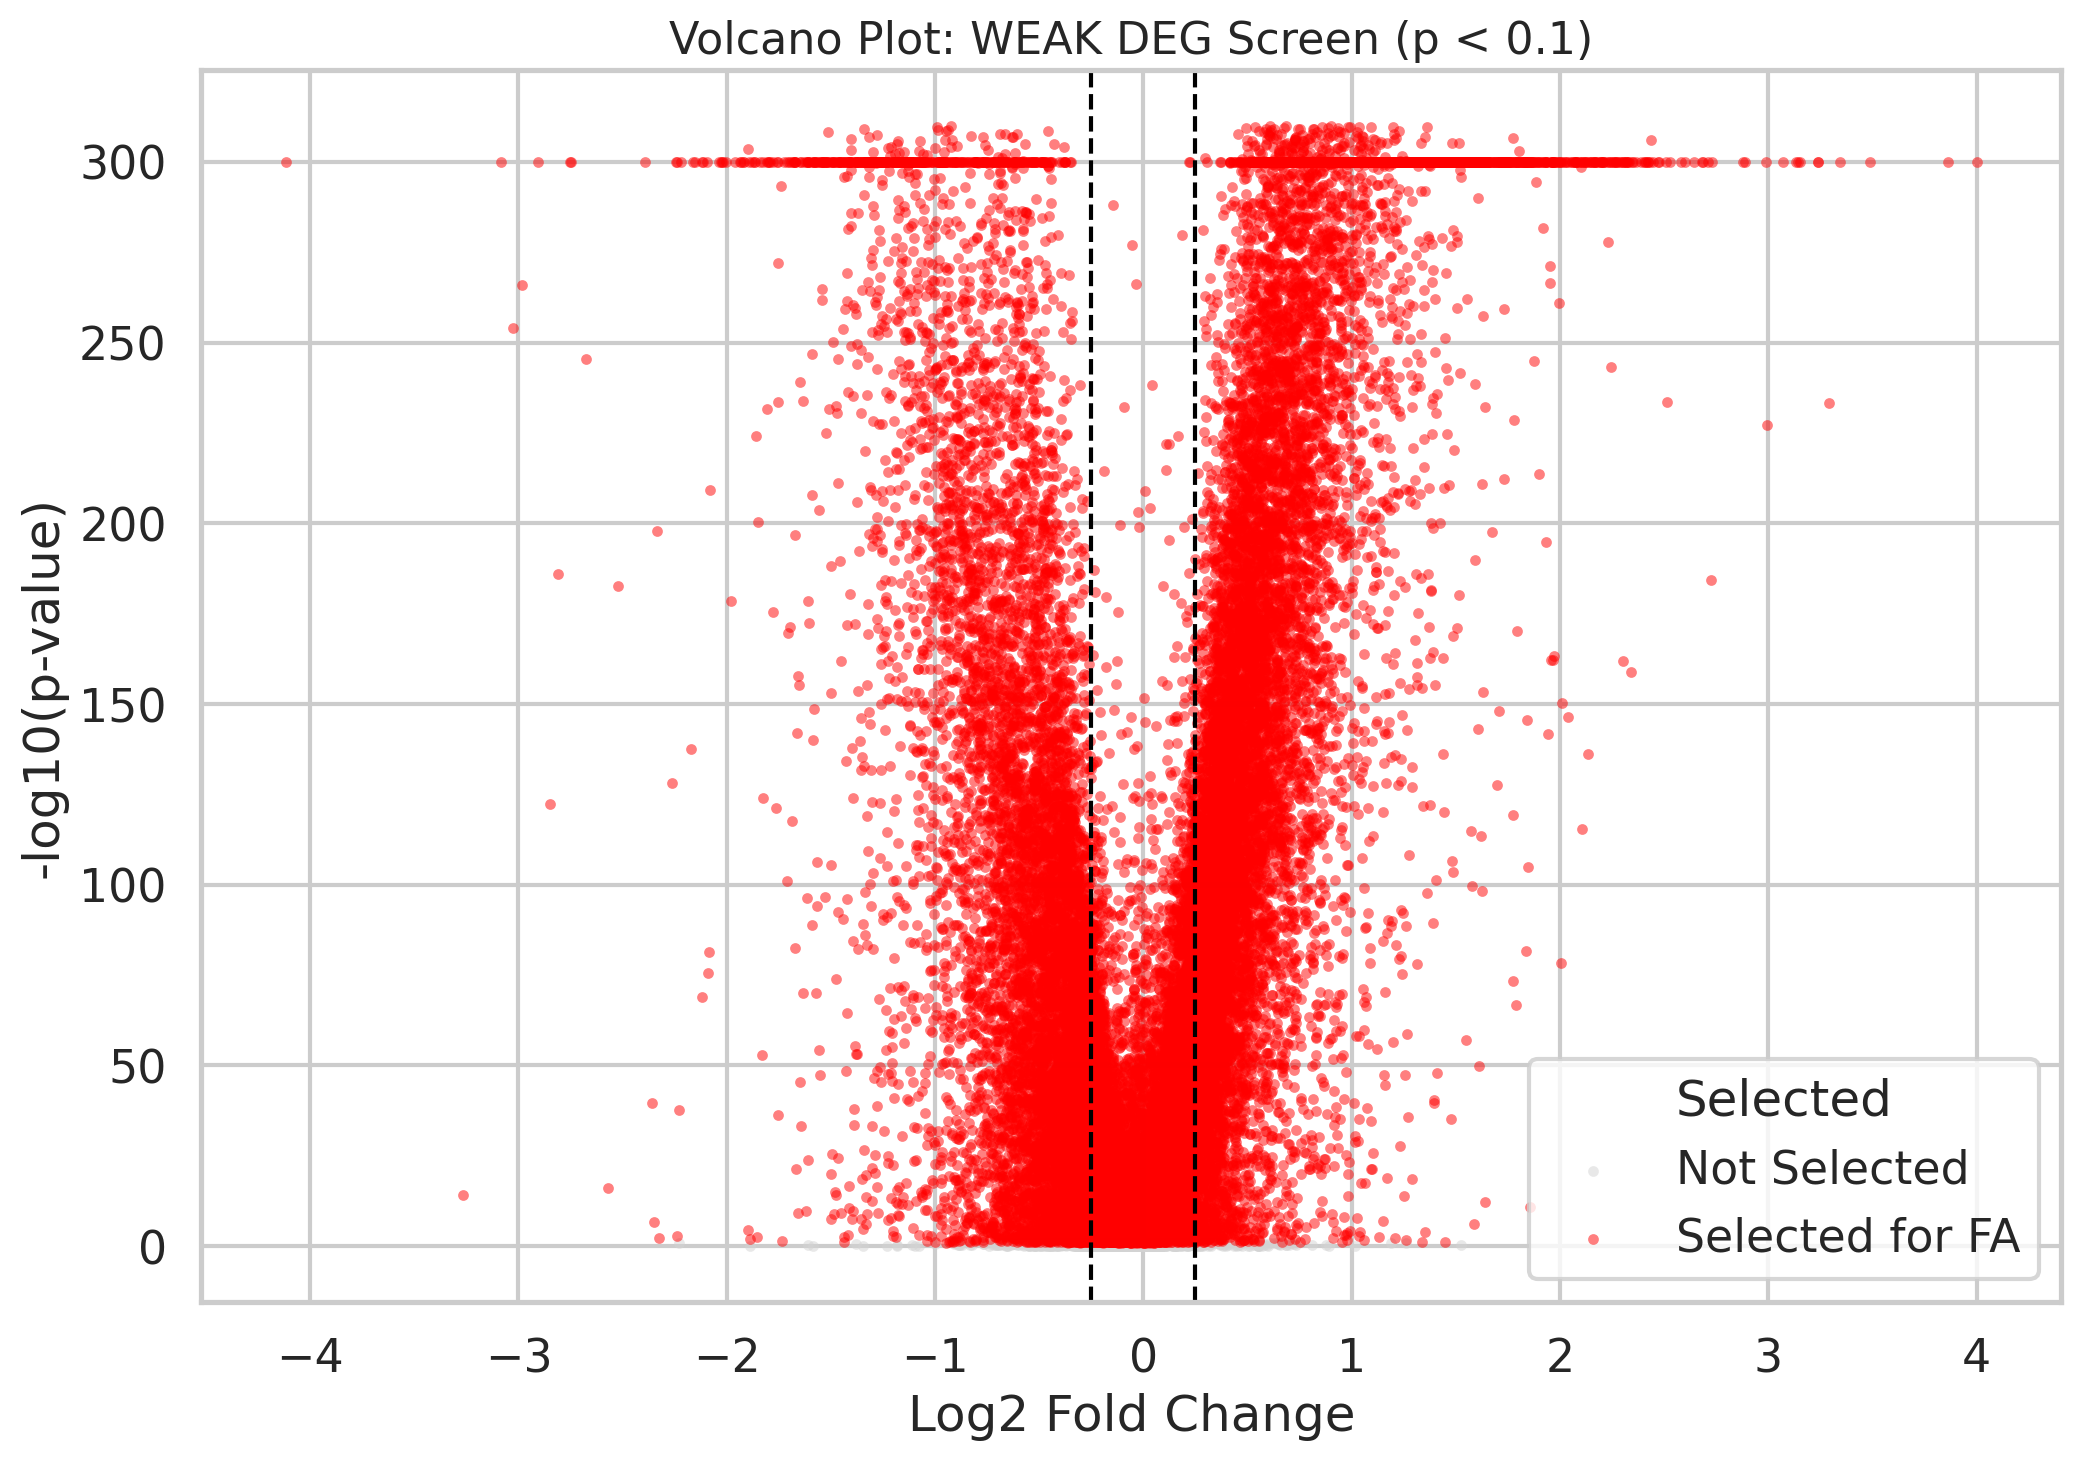


Calculating DEGs for STRONGER screen (q < 0.05)...


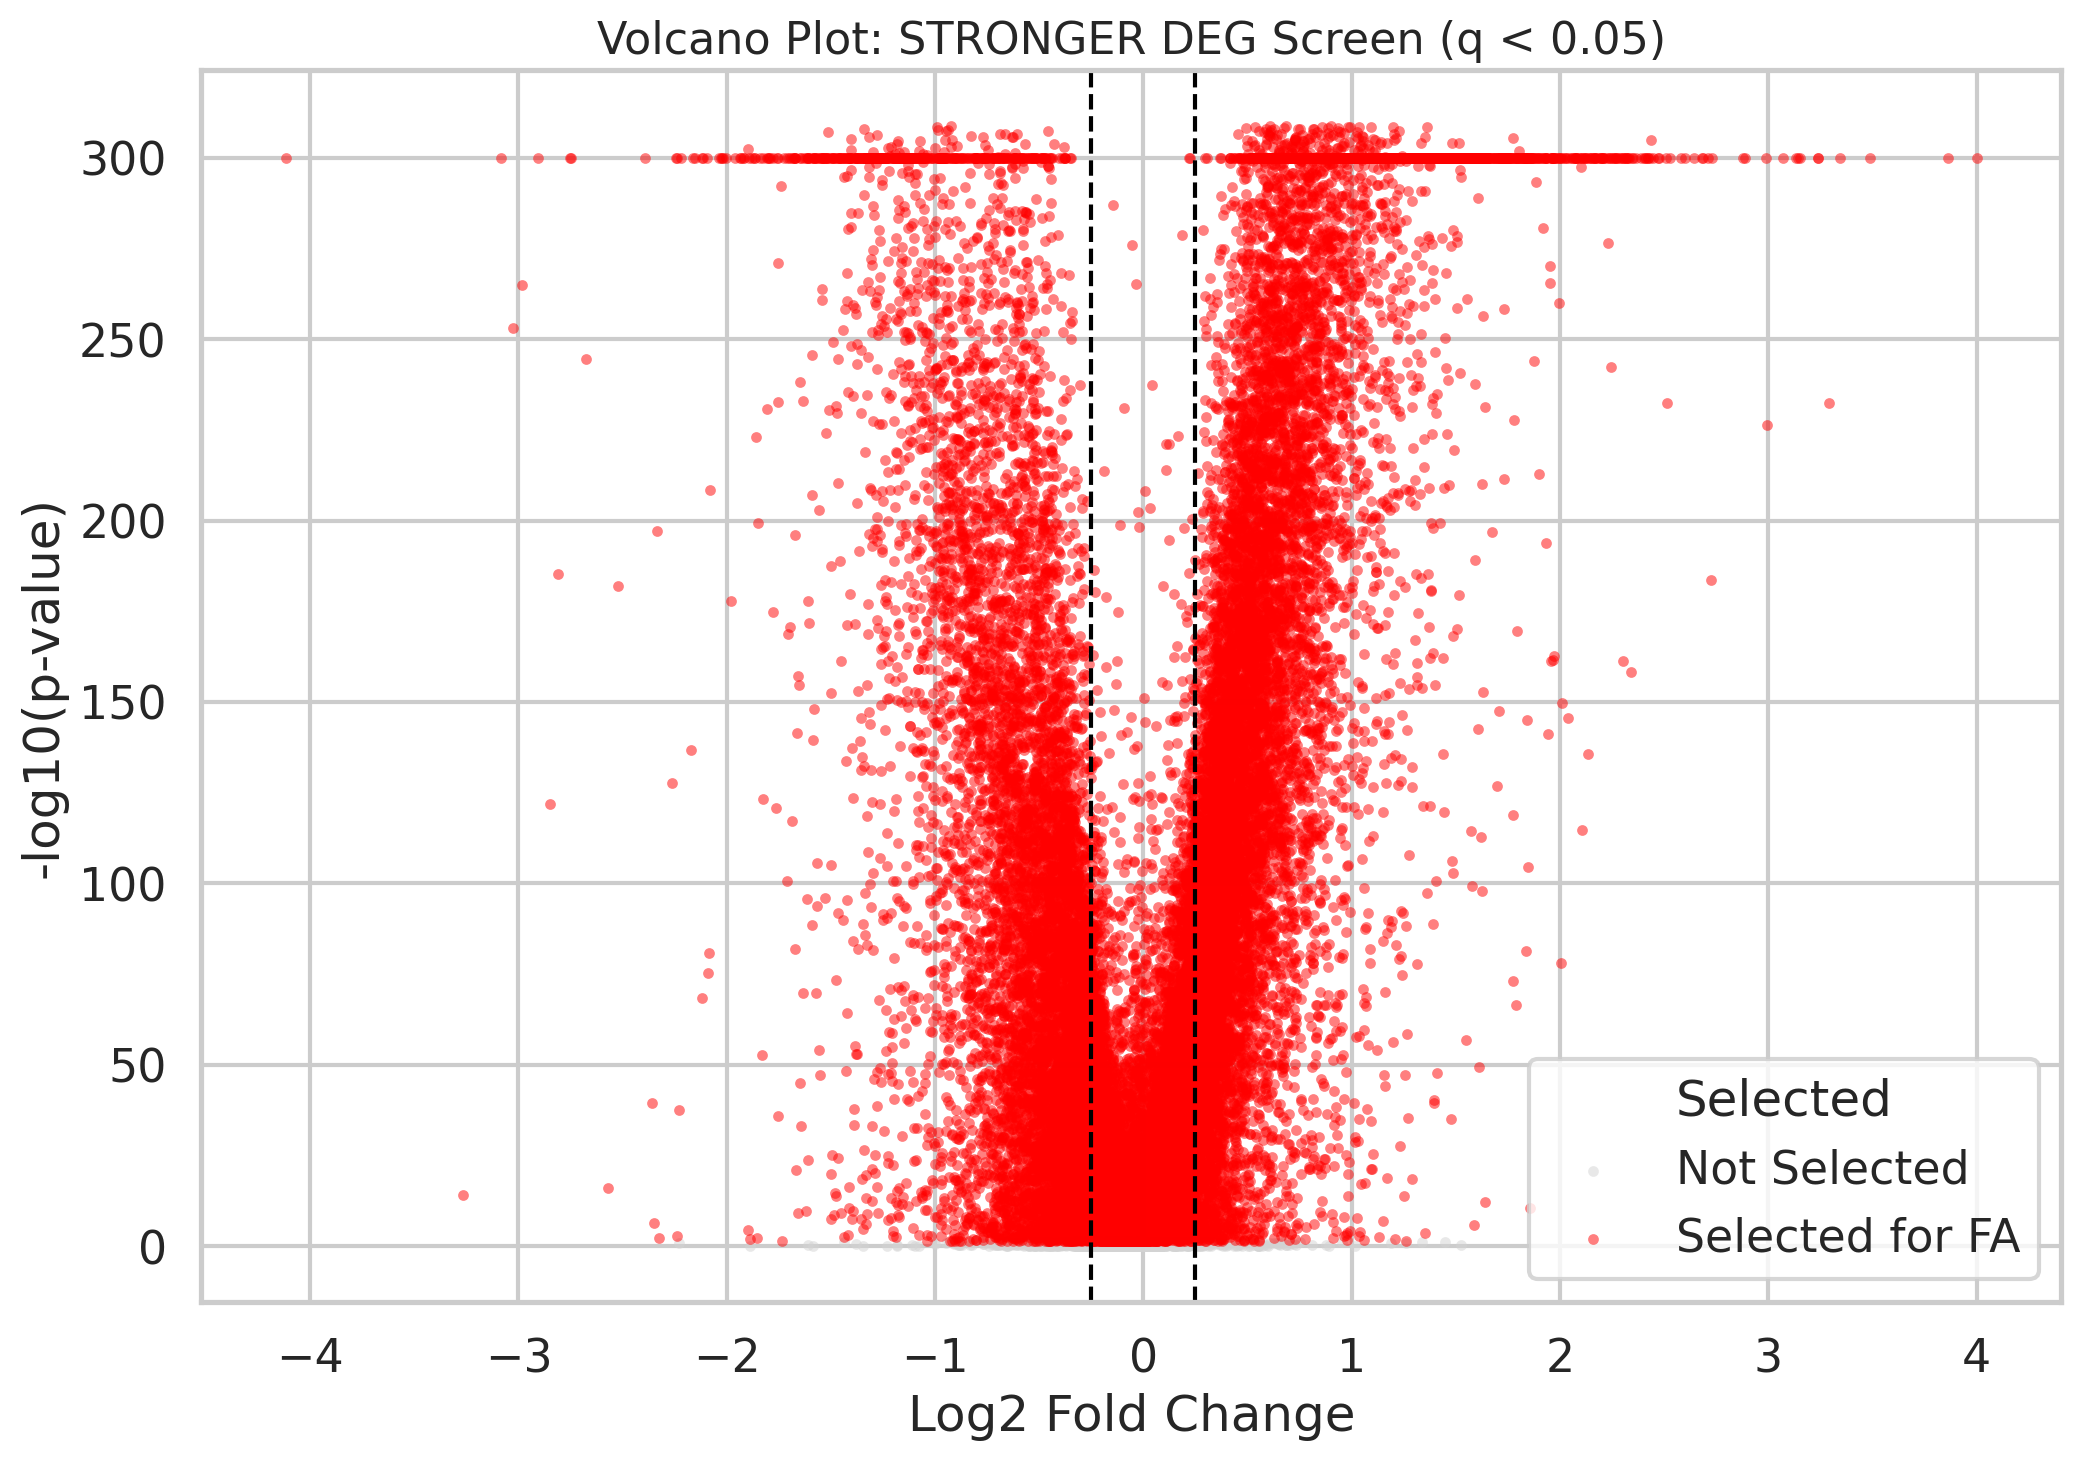

In [5]:
# In your notebook, replace the volcano plot cell with this self-contained version:

# --- Gene List Loading and Volcano Plot Generation ---

# 1. Load all necessary gene lists first
print("--- Loading Gene Lists for Plotting ---")
gene_lists = {}
for key, exp_data in experiments.items():
    gene_list_path = exp_data["path"] / "preprocessing" / "hvg_list.pkl"
    with open(gene_list_path, 'rb') as f:
        gene_lists[key] = set(pickle.load(f))
        print(f"Loaded gene list for '{exp_data['label']}': {len(gene_lists[key])} genes.")

# 2. To create the volcano plot, we need to re-run the DE test on the base data.
print("\n--- Generating Volcano Plots for DEG Screens ---")
print("Loading and preparing base filtered data...")
input_data_path = "/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad"
adata_raw = sc.read_h5ad(input_data_path)
adata_filtered = adata_raw[adata_raw.obs['timepoint_type'] == 'MRD'].copy()
valid_targets = ['cancer', 'normal']
target_mask = adata_filtered.obs['CN.label'].isin(valid_targets) & ~adata_filtered.obs['CN.label'].isna()
adata_filtered = adata_filtered[target_mask].copy()
print(f"Base filtered data shape: {adata_filtered.shape}")

# 3. Define the plotting function
def create_volcano_plot(adata_base, selected_genes_set, title, pval_key='pvals', lfc_key='logfoldchanges', lfc_threshold=0.25):
    de_results = sc.get.rank_genes_groups_df(adata_base, group='cancer')
    de_results['-log10_pval'] = -np.log10(de_results[pval_key].replace(0, 1e-300))
    de_results['selected'] = de_results['names'].isin(selected_genes_set)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=de_results[~de_results['selected']], x=lfc_key, y='-log10_pval', color='lightgray', alpha=0.5, s=15, linewidth=0, label='Not Selected')
    sns.scatterplot(data=de_results[de_results['selected']], x=lfc_key, y='-log10_pval', color='red', alpha=0.5, s=15, linewidth=0, label='Selected for FA')
    plt.axvline(x=lfc_threshold, color='black', linestyle='--', lw=1.5)
    plt.axvline(x=-lfc_threshold, color='black', linestyle='--', lw=1.5)
    plt.title(title, fontsize=16)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("-log10(p-value)")
    plt.legend(title='Selected')
    plt.grid(True)
    plt.show()

# 4. Generate the plots
print("\nCalculating DEGs for WEAK screen (p < 0.1)...")
sc.tl.rank_genes_groups(adata_filtered, groupby='CN.label', groups=['cancer'], reference='normal', method='wilcoxon')
create_volcano_plot(adata_filtered, gene_lists['deg_weak_screen'], 'Volcano Plot: WEAK DEG Screen (p < 0.1)')

print("\nCalculating DEGs for STRONGER screen (q < 0.05)...")
sc.tl.rank_genes_groups(adata_filtered, groupby='CN.label', groups=['cancer'], reference='normal', method='wilcoxon')
create_volcano_plot(adata_filtered, gene_lists['deg_stronger_screen'], 'Volcano Plot: STRONGER DEG Screen (q < 0.05)', pval_key='pvals_adj')

#### Unsupervised Diagnosis and GSEA on each factor's loading

In [8]:
# Initialize the analyzer
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

# --- Generate FA Diagnostic plots for all experiments ---
for key, exp_data in experiments.items():
    analyzer.generate_fa_diagnostic_plots(exp_data['id'])

--- Generating FA-specific diagnostic plots ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b
  Saved SS Loadings plot to /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b/analysis/dimension_reduction_diagnostics/ss_loadings_per_factor.png
  Saved Gene Communality plot to /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b/analysis/dimension_reduction_diagnostics/gene_communality_distribution.png
--- Generating FA-specific diagnostic plots ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_022711_fa_100_random_deg_weak_screen_95a75afb
  Saved SS Loadings plot to /home/minhang/mds_project/sc_classification/experiments/20250811_022711_fa_100_random_deg_weak_screen_95a75afb/analysis/dimension_reduction_diagnostics/ss_loadings_per_factor.png
  Saved 

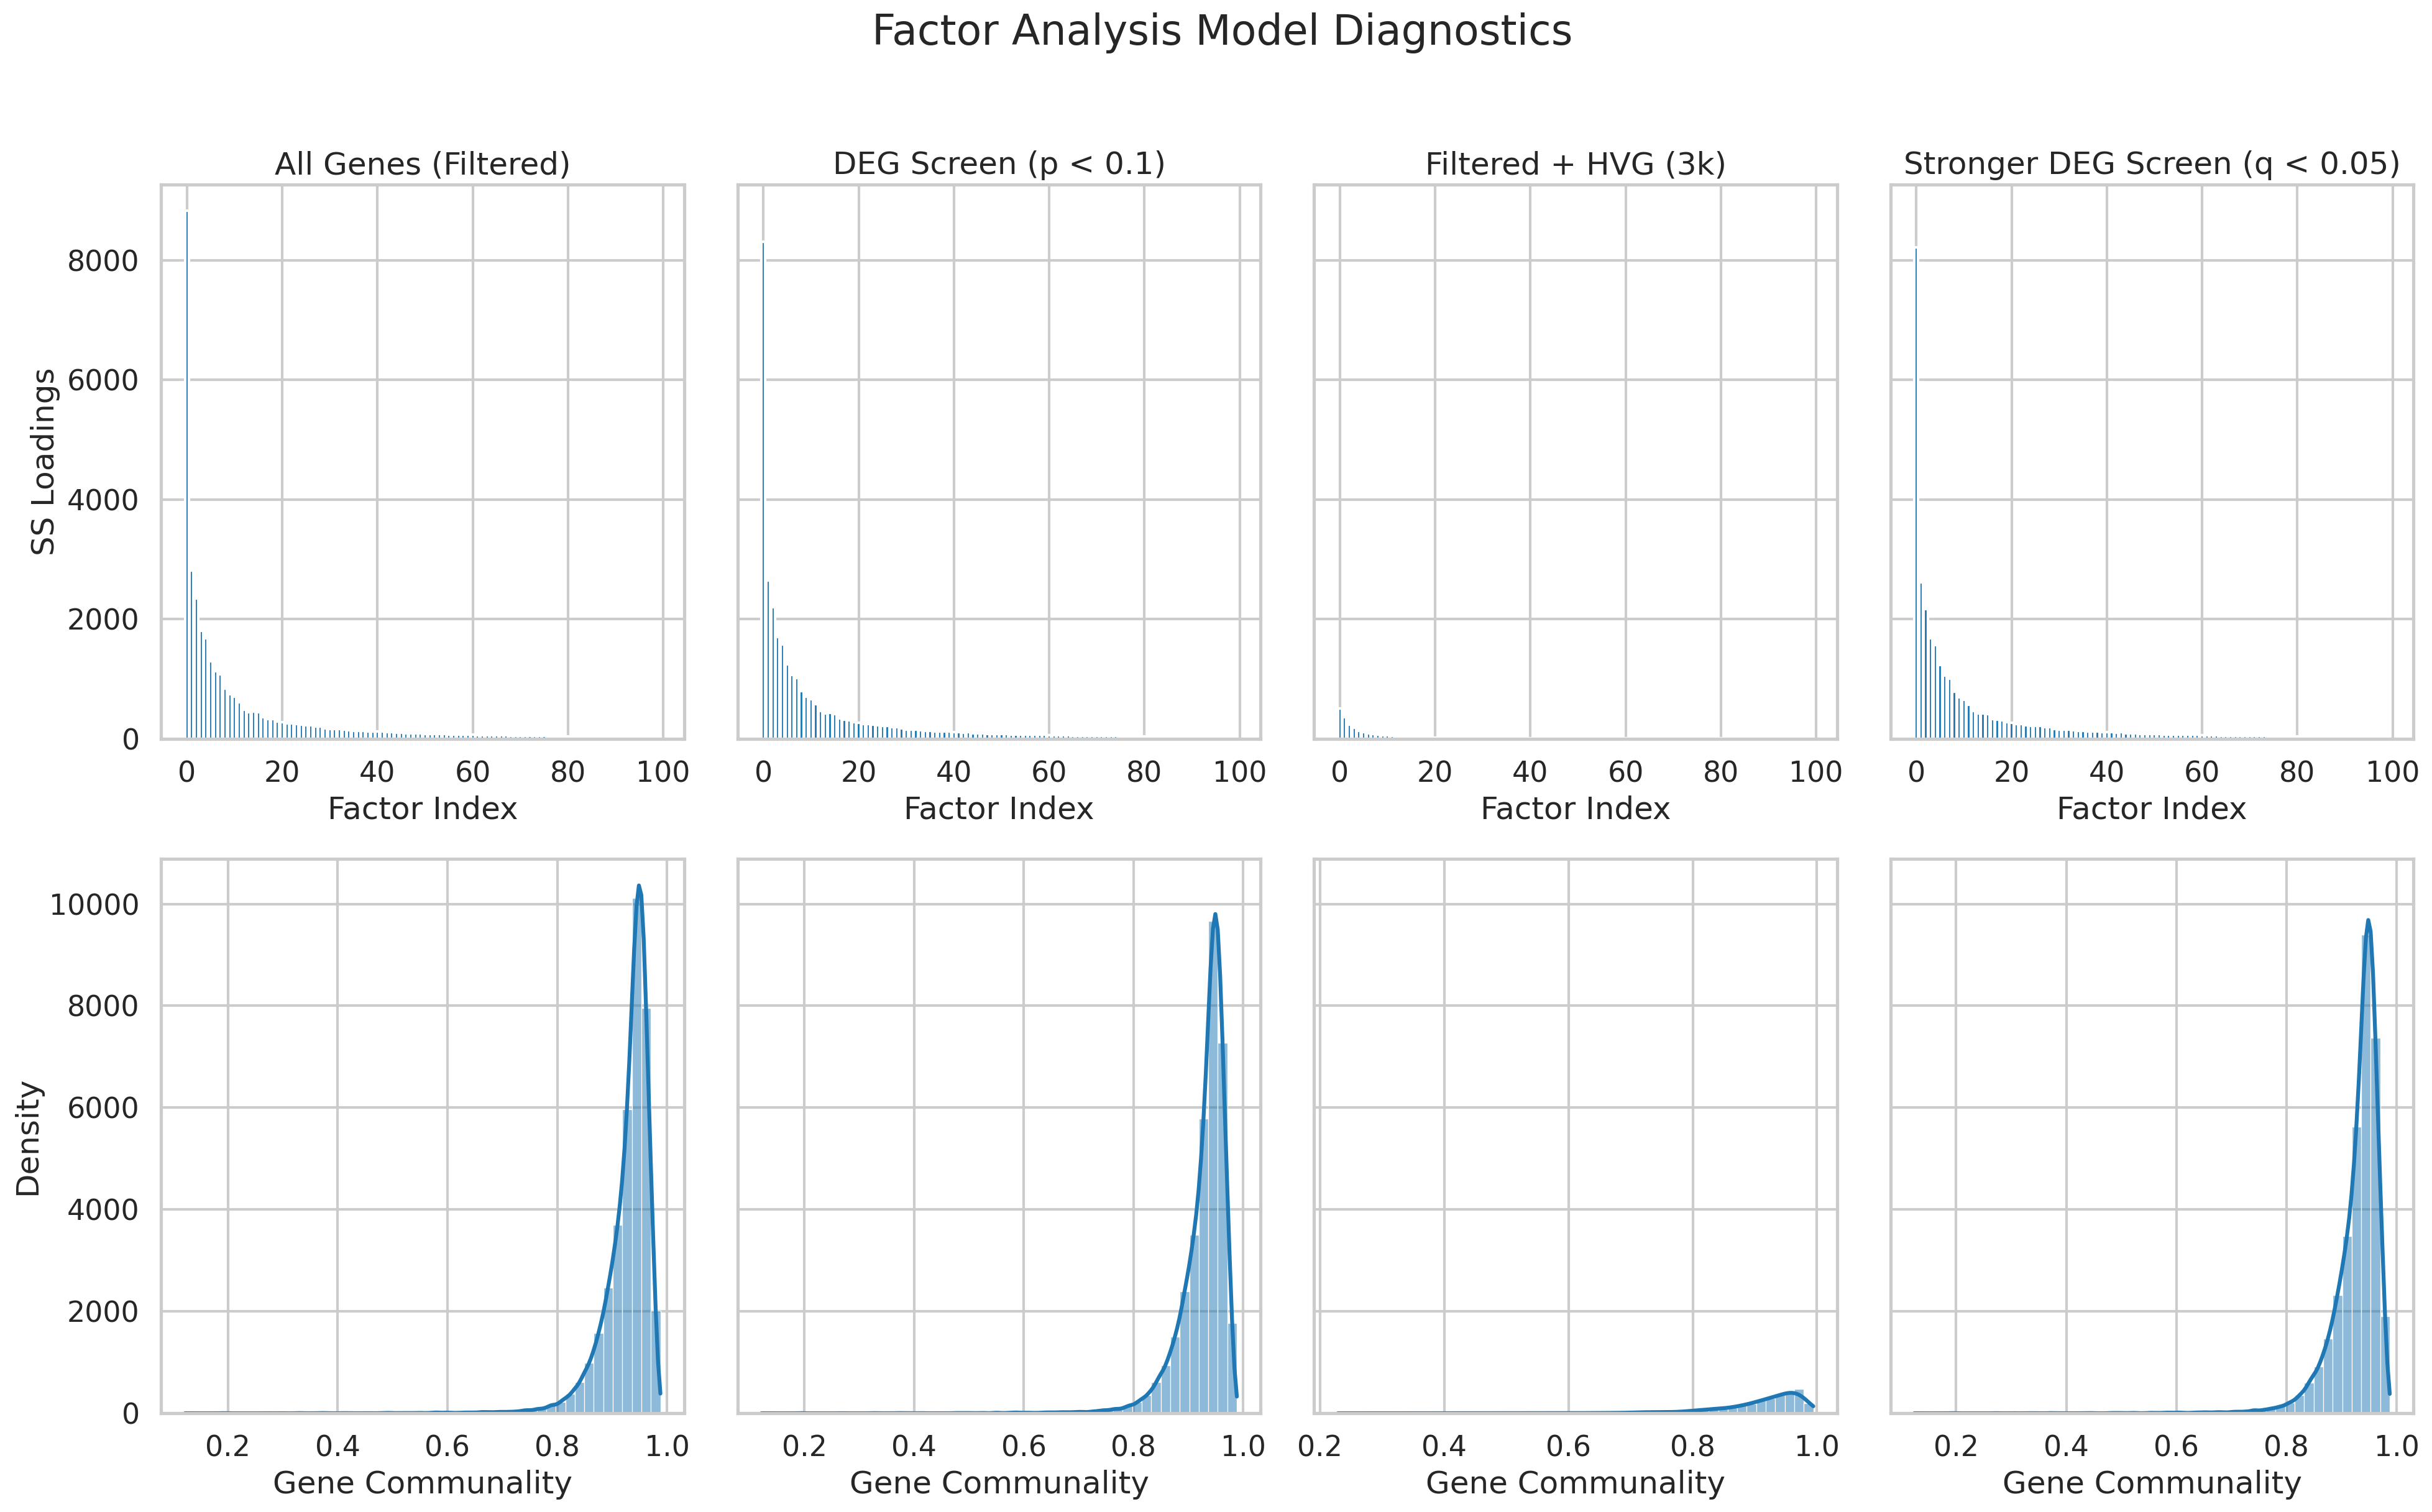

In [9]:
# In a new cell: Unsupervised Diagnosis Plots
fig, axes = plt.subplots(2, 4, figsize=(20, 12), sharey='row')
fig.suptitle("Factor Analysis Model Diagnostics", fontsize=24, y=1.02)

for i, (key, exp_data) in enumerate(experiments.items()):
    # Load the transformed data which contains model details
    adata_path = exp_data["path"] / "models" / "fa_100" / "transformed_data.h5ad"
    adata = sc.read_h5ad(adata_path)

    # Panel 1: Sum of Square (SS) Loadings per Factor
    ss_loadings = adata.uns['fa']['ss_loadings_per_factor']
    axes[0, i].bar(range(len(ss_loadings)), ss_loadings)
    axes[0, i].set_title(exp_data['label'])
    axes[0, i].set_xlabel("Factor Index")

    # Panel 2: Gene Communality Distribution
    communality = adata.var['communality']
    sns.histplot(communality, ax=axes[1, i], bins=50, kde=True)
    axes[1, i].set_xlabel("Gene Communality")

axes[0, 0].set_ylabel("SS Loadings")
axes[1, 0].set_ylabel("Density")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

GSEA on each factors for each experiment

In [1]:
'''
manager = ExperimentManager(BASE_EXPERIMENT_DIR)

# --- FIX: Pass the manager object to the analyzer ---
analyzer = ExperimentAnalyzer(manager)

# --- 1. Run GSEA for all experiments using the corrected analyzer ---
for key, exp_data in experiments.items():
    print("\n" + "="*80)
    print(f"RUNNING GSEA ON ORIGINAL LOADINGS FOR: {exp_data['label']}")
    print("="*80)
    analyzer.run_gsea_on_factors(
        experiment_id=exp_data['id'],
        rescale_loadings=False 
    )

# --- 2. Generate Per-Patient Reports using the corrected analyzer ---
for key, exp_data in experiments.items():
    print("\n" + "="*80)
    print(f"Generating 2-Panel Lasso Reports for: {exp_data['label']}")
    print("="*80)
    
    try:
        # This function should now work correctly
        analyzer.generate_lasso_path_2panels_report(exp_data['id'])
        
        # Verify where the files were saved
        output_dir = exp_data["path"] / "analysis" / "summary_plots"
        print(f"Reports for {exp_data['label']} should be saved in: {output_dir}")

    except Exception as e:
        print(f"Could not generate reports for {exp_data['label']}: {e}")
'''

'\nmanager = ExperimentManager(BASE_EXPERIMENT_DIR)\n\n# --- FIX: Pass the manager object to the analyzer ---\nanalyzer = ExperimentAnalyzer(manager)\n\n# --- 1. Run GSEA for all experiments using the corrected analyzer ---\nfor key, exp_data in experiments.items():\n    print("\n" + "="*80)\n    print(f"RUNNING GSEA ON ORIGINAL LOADINGS FOR: {exp_data[\'label\']}")\n    print("="*80)\n    analyzer.run_gsea_on_factors(\n        experiment_id=exp_data[\'id\'],\n        rescale_loadings=False \n    )\n\n# --- 2. Generate Per-Patient Reports using the corrected analyzer ---\nfor key, exp_data in experiments.items():\n    print("\n" + "="*80)\n    print(f"Generating 2-Panel Lasso Reports for: {exp_data[\'label\']}")\n    print("="*80)\n    \n    try:\n        # This function should now work correctly\n        analyzer.generate_lasso_path_2panels_report(exp_data[\'id\'])\n        \n        # Verify where the files were saved\n        output_dir = exp_data["path"] / "analysis" / "summary_plo

Generate per-patient 2-panels report

In [12]:
for key, exp_data in experiments.items():
    print("\n" + "="*80)
    print(f"Generating 2-Panel Lasso Reports for: {exp_data['label']}")
    print("="*80)
    
    analyzer.generate_lasso_path_2panels_report(exp_data['id'])



Generating 2-Panel Lasso Reports for: All Genes (Filtered)
--- Generating Standard Analysis Report for Experiment: 20250811_015935_fa_100_random_all_filtered_9be6903b ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b
Generating plot for patient: P01
  Saved plot to /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b/analysis/summary_plots/patient_P01_metrics_and_coefficients.png
Generating plot for patient: P02
  Saved plot to /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b/analysis/summary_plots/patient_P02_metrics_and_coefficients.png
Generating plot for patient: P03
  Saved plot to /home/minhang/mds_project/sc_classification/experiments/20250811_015935

In [5]:
all_filtered_2_panel_indices_to_analyze = {
    "P01": [10, 11, 12, 13, 14],
    "P02": [13, 14, 15, 16],
    "P03": [17], 
    "P04": [11, 12, 13, 14, 15],
    "P05": [10, 11, 12, 13, 14],
    "P06": [9, 10, 11, 12, 13, 14], 
    "P07": [9, 10, 11, 12, 13],
    "P09": [12, 13, 14, 15, 16, 17],
    "P13": [10, 11, 12, 13]
}


deg_weak_screen_2_panel_indices_to_analyze = {
    "P01": [10, 11, 12, 13, 14],
    "P02": [13, 14, 15, 16],
    "P03": [17], 
    "P04": [11, 12, 13, 14, 15],
    "P05": [10, 11, 12, 13, 14],
    "P06": [8, 9, 10, 11, 12, 13, 14], 
    "P07": [9, 10, 11, 12, 13],
    "P09": [12, 13, 14, 15, 16, 17],
    "P13": [10, 11, 12, 13]
}

hvg_2_panel_indices_to_analyze = {
    "P01": [9, 10, 11, 12, 13, 14],
    "P02": [13, 14, 15, 16],
    "P03": [17], 
    "P04": [11, 12, 13, 14],
    "P05": [10, 11, 12, 13, 14],
    "P06": [8, 9, 10, 11, 12, 13, 14], 
    "P07": [9, 10, 11, 12, 13],
    "P09": [12, 13, 14, 15, 16, 17],
    "P13": [10, 11, 12, 13]
}

stronger_deg_screen_2_panel_indices_to_analyze = {
    "P01": [9, 10, 11, 12, 13, 14],
    "P02": [14, 15, 16],
    "P03": [17], 
    "P04": [11, 12, 13, 14, 15],
    "P05": [10, 11, 12, 13, 14],
    "P06": [8, 9, 10, 11, 12, 13, 14], 
    "P07": [9, 10, 11, 12, 13],
    "P09": [12, 13, 14, 15, 16, 17],
    "P13": [10, 11, 12, 13]
}

In [6]:
# In a new cell: Create a master dictionary for the alpha indices

# This dictionary will hold the indices for all experiments, making it easy to loop through them.
all_exp_indices = {
    "all_filtered": all_filtered_2_panel_indices_to_analyze,
    "deg_weak_screen": deg_weak_screen_2_panel_indices_to_analyze,
    "filtered_hvg": hvg_2_panel_indices_to_analyze,
    "deg_stronger_screen": stronger_deg_screen_2_panel_indices_to_analyze
}

### Run GSEA on predictive loading

In [12]:
'''
# takes 14 mins 20 secs to run
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

for key, indices_dict in all_exp_indices.items():
    exp_data = experiments[key]
    print("\n" + "="*80)
    print(f"RUNNING PREDICTIVE LOADING GSEA FOR: {exp_data['label']}")
    print("="*80)

    # This calls the new function in your ExperimentAnalyzer
    analyzer.run_predictive_loading_gsea(
        experiment_id=exp_data['id'],
        patient_reg_strength_indices=indices_dict
    )

print("\n\nPredictive Loading GSEA analysis complete for all experiments.")

'''

'\n# takes 14 mins 20 secs to run\nmanager = ExperimentManager(BASE_EXPERIMENT_DIR)\nanalyzer = ExperimentAnalyzer(manager)\n\nfor key, indices_dict in all_exp_indices.items():\n    exp_data = experiments[key]\n    print("\n" + "="*80)\n    print(f"RUNNING PREDICTIVE LOADING GSEA FOR: {exp_data[\'label\']}")\n    print("="*80)\n\n    # This calls the new function in your ExperimentAnalyzer\n    analyzer.run_predictive_loading_gsea(\n        experiment_id=exp_data[\'id\'],\n        patient_reg_strength_indices=indices_dict\n    )\n\nprint("\n\nPredictive Loading GSEA analysis complete for all experiments.")\n\n'

In [ ]:
'''
# takes 17 mins to run
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

for key, indices_dict in all_exp_indices.items():
    exp_data = experiments[key]
    print("\n" + "="*80)
    print(f"RUNNING TRANSITION ANALYSIS & UMAPs FOR: {exp_data['label']}")
    print("="*80)

    # First, run the transition analysis to generate the JSON files
    for patient_id, indices in indices_dict.items():
        analyzer.analyze_classification_transitions(
            experiment_id=exp_data['id'],
            patient_id=patient_id,
            indices_to_check=indices
        )

    # Then, generate the UMAP plots for all patients in this experiment
    analyzer.generate_classification_umap_report(
        experiment_id=exp_data['id'],
        patient_reg_strength_indices=indices_dict,
        static_umap_rep='X_multivi'
    )
'''


RUNNING TRANSITION ANALYSIS & UMAPs FOR: All Genes (Filtered)
--- Analyzing Classification Transitions for Patient P01 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...
  Analyzing transition from index 12 to 11...
  Analyzing transition from index 11 to 10...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b/models/classification/P01/classification_transitions.json
--- Analyzing Classification Transitions for Patient P02 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_015935_fa_100_random_all_filtered_9be6903b
  Analyzing transition from index 16 to 15...
  Analyzing transition from index 15 to 14...
  Analyzing transition from index 14 to 13...

Successfully sav

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P01.

Processing patient: P02
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P02.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P02.

Processing patient: P03
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P03.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P03.

Processing patient: P04
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P04.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 15: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P04.

Processing patient: P05
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P05.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 14: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P05.

Processing patient: P06
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P06.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P06.

Processing patient: P07
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P07.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P07.

Processing patient: P09
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P09.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P09.

Processing patient: P13
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P13.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P13.

--- Report generation complete. ---

RUNNING TRANSITION ANALYSIS & UMAPs FOR: DEG Screen (p < 0.1)
--- Analyzing Classification Transitions for Patient P01 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_022711_fa_100_random_deg_weak_screen_95a75afb
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...
  Analyzing transition from index 12 to 11...
  Analyzing transition from index 11 to 10...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_classification/experiments/20250811_022711_fa_100_random_deg_weak_screen_95a75afb/models/classification/P01/classification_transitions.json
--- Analyzing Classification Transitions for Patie

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


    Index 16: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P02.

Processing patient: P03
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P03.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P03.

Processing patient: P04
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P04.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 15: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P04.

Processing patient: P05
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P05.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P05.

Processing patient: P06
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P06.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P06.

Processing patient: P07
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P07.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P07.

Processing patient: P09
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P09.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P09.

Processing patient: P13
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P13.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P13.

--- Report generation complete. ---

RUNNING TRANSITION ANALYSIS & UMAPs FOR: Filtered + HVG (3k)
--- Analyzing Classification Transitions for Patient P01 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_025926_fa_100_random_all_filtered-hvg_d649c8b5
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...
  Analyzing transition from index 12 to 11...
  Analyzing transition from index 11 to 10...
  Analyzing transition from index 10 to 9...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_classification/experiments/20250811_025926_fa_100_random_all_filtered-hvg_d649c8b5/models/classification/P01/classification_transitions.json
--- 

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P02.

Processing patient: P03
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P03.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P03.

Processing patient: P04
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P04.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P04.

Processing patient: P05
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P05.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 14: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P05.

Processing patient: P06
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P06.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P06.

Processing patient: P07
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P07.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P07.

Processing patient: P09
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P09.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P09.

Processing patient: P13
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P13.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P13.

--- Report generation complete. ---

RUNNING TRANSITION ANALYSIS & UMAPs FOR: Stronger DEG Screen (q < 0.05)
--- Analyzing Classification Transitions for Patient P01 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250811_170003_fa_100_random_deg_weak_screen_d6fa547e
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...
  Analyzing transition from index 12 to 11...
  Analyzing transition from index 11 to 10...
  Analyzing transition from index 10 to 9...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_classification/experiments/20250811_170003_fa_100_random_deg_weak_screen_d6fa547e/models/classification/P01/classification_transitions.

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P03.

Processing patient: P04
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P04.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 15: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P04.

Processing patient: P05
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P05.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 14: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P05.

Processing patient: P06
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P06.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P06.

Processing patient: P07
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P07.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P07.

Processing patient: P09
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P09.
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P09.

Processing patient: P13
  Generating Static UMAPs based on: 'X_multivi'
  Finished static UMAPs for patient P13.
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P13.

--- Report generation complete. ---
